In [2]:
!pip install yellowbrick

     -------------------------------------- 282.6/282.6 kB 4.3 MB/s eta 0:00:00


In [64]:
#Importing the required modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, classification_report, confusion_matrix, r2_score, 
    accuracy_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
import numpy as np
from scipy.stats import shapiro, normaltest, skew
from scipy.stats import chi2_contingency


# Introduction 

## Project Title: Analyzing the Impact of Barclays' Apprenticeships

This project investigates the influence of Barclays' apprenticeship program on career progression. We compare 1500 apprentices' highest achieved grades with those of 1500 non-apprentices who also began at grade 2. By examining factors like age and apprenticeship type, we aim to uncover insights into the program's effectiveness. The study's findings will guide data-driven talent management decisions, benefiting both individuals and the organization. This research illuminates the transformative potential of apprenticeships, in bridging the gap between education and employment in the corporate world.

About the data: 
The data was collected from the data stored in Vantage on every employee in Barclays. The data contains the Apprenticeship type, age, and the highest corporate grade that an apprentice had achieved. Foundation apprentices are usually enrolled on a level 3 qualification (equivalent to A levels) and complete a 2 year program and Higher Apprentices are usually enrolled on a degree level qualification and complete a 4 year program. Another type of apprenticeship called 'Destination Technology' is also included and falls under 'Other Type of Apprenticeship' in the data. This included people who may have undertaken an Apprenticeship after already being employed for a number of years, and they often involve career changes, and team moves. For example a customer facing colleague in a branch may need to be re-trained in a technology role through an apprenticeship due to changing business requirements as well as individual desires for a career change. Before putting through Python models, the data has been fully anonymise with names, ID's, and DOB all removed, and no personally identifiable data remains.

# Data preperation

In [25]:
#setting file path
file_path = 'C:\\Users\\asus\\Downloads\\Anonymous_apprentice_data (2).csv'
df = pd.read_csv(file_path)

df.head()

,AGE_GROUP,AVP,BA4,BRID,CORPORATE_GRADE,APPRENTICESHIP_TYPE,age
0,18-24,0,0,G01111049,BA2,Foundation Apprentice,17
1,18-24,0,0,G01111050,BA2,Foundation Apprentice,17
2,18-24,0,0,G01111051,BA2,other types or not specified,17
3,18-24,0,0,G01111052,BA2,Foundation Apprentice,17
4,18-24,0,0,G01111053,BA2,Higher Apprentice,17


In [69]:
df.shape

(2746, 7)

In [70]:
apprentice_counts = df['APPRENTICESHIP_TYPE'].value_counts()

non_apprentice_count = (df['APPRENTICESHIP_TYPE'] == 'NO APPRENTICESHIP').sum()

print("Number of Foundation Apprentices:", apprentice_counts.get('Foundation Apprentice', 0))
print("Number of Higher Apprentices:", apprentice_counts.get('Higher Apprentice', 0))
print("Number of Other Types or Not Specified:", apprentice_counts.get('other types or not specified', 0))
print("Number of Non-Apprentices (NO APPRENTICESHIP):", non_apprentice_count)

Number of Foundation Apprentices: 297
Number of Higher Apprentices: 545
Number of Other Types or Not Specified: 580
Number of Non-Apprentices (NO APPRENTICESHIP): 1324


In [71]:
# cleaning steps 
df.isnull().sum()

df = df.rename(columns={'age ': 'age'})

duplicates = df[df.duplicated()]

# Display the duplicated rows
print(duplicates)

unique_values = df['APPRENTICESHIP_TYPE'].unique()
print(unique_values)

Empty DataFrame
Columns: [AGE_GROUP, AVP, BA4, BRID, CORPORATE_GRADE, APPRENTICESHIP_TYPE, age]
Index: []
['Foundation Apprentice' 'other types or not specified'
 'Higher Apprentice' 'NO APPRENTICESHIP']


# Data Exploration

In [33]:
filtered_df = df[df['APPRENTICESHIP_TYPE'] != 'NO APPRENTICESHIP']

age_stats = filtered_df.groupby('APPRENTICESHIP_TYPE')['age'].agg(['max', 'min'])

print("Highest and Lowest Age for Each Type of Apprenticeship (Excluding 'NO APPRENTICESHIP'):")
print(age_stats)

Highest and Lowest Age for Each Type of Apprenticeship (Excluding 'NO APPRENTICESHIP'):
                              max  min
APPRENTICESHIP_TYPE                   
Foundation Apprentice          61   17
Higher Apprentice              56   17
other types or not specified   65   17


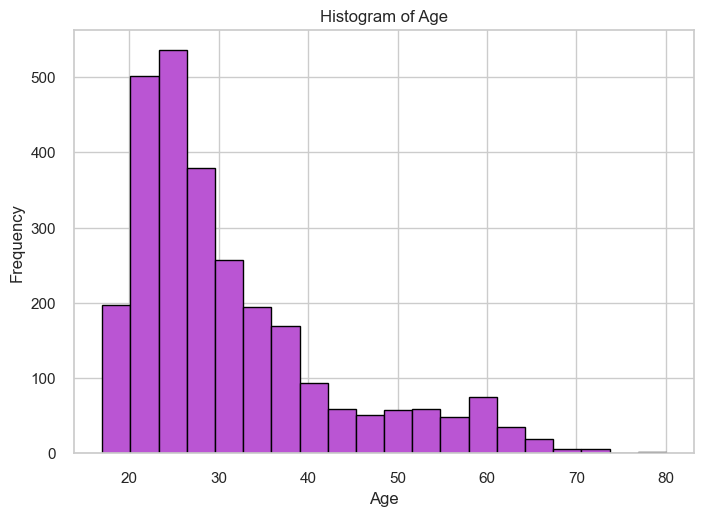

In [73]:
#Looking at the distribution of age accross the data set

plt.hist(df['age'], bins=20, color='mediumorchid', edgecolor='black')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')

plt.show()

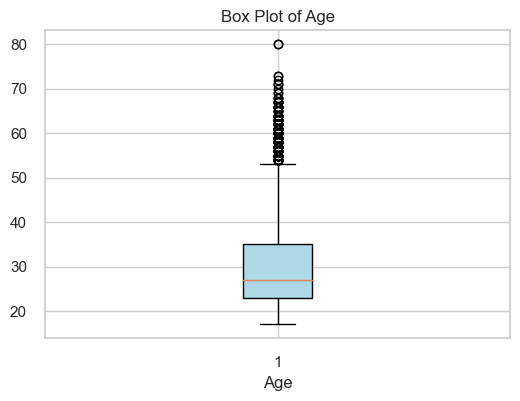

In [74]:
#Box plot
plt.figure(figsize=(6, 4)) 
plt.boxplot(df['age'], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.xlabel('Age')
plt.title('Box Plot of Age')

plt.show()

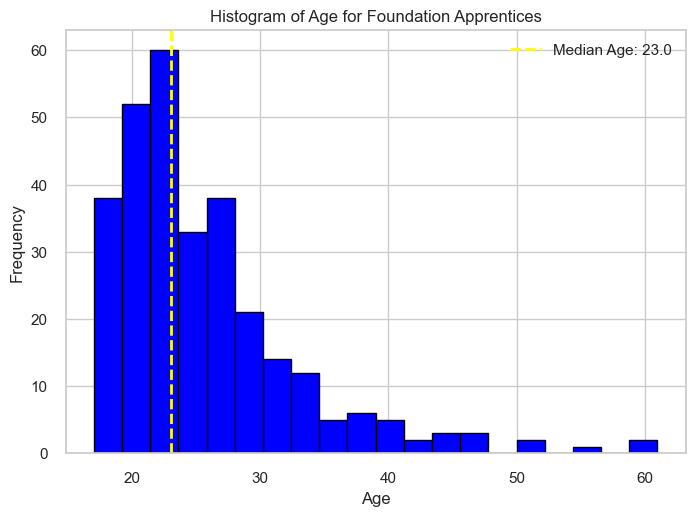

In [76]:
#Histogram for foundation apprentices vs age
foundation_apprentices_df = df[df['APPRENTICESHIP_TYPE'] == 'Foundation Apprentice']

plt.hist(foundation_apprentices_df['age'], bins=20, color='blue', edgecolor='black')

# Calculating the median age
median_age = foundation_apprentices_df['age'].median()

# Adding a vertical line at the median age
plt.axvline(median_age, color='yellow', linestyle='dashed', linewidth=2, label=f'Median Age: {median_age}')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age for Foundation Apprentices')
plt.legend()

plt.show()

#After seeing the histogram for Age, I can see that there is a right skewed distribution. This is quite expected since I am analysing apprenticeships which are generally undertaken mostly by younger people

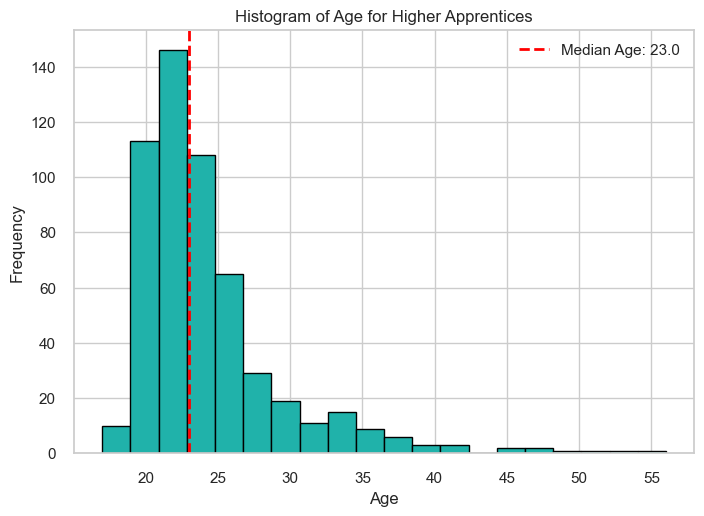

In [79]:
#Histogram for Higher Apprentices only 

#filtering the data 
higher_apprentices_df = df[df['APPRENTICESHIP_TYPE'] == 'Higher Apprentice']

# Plotting data
plt.hist(higher_apprentices_df['age'], bins=20, color='lightseagreen', edgecolor='black')

# Calculate the median age
median_age = higher_apprentices_df['age'].median()

# Add a vertical line at the median age
plt.axvline(median_age, color='red', linestyle='dashed', linewidth=2, label=f'Median Age: {median_age}')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age for Higher Apprentices')
plt.legend()

plt.show()

#Similarily to the histogram above, there is a right skewed distribution, furthrmore there seem to be more age diversity in this selection

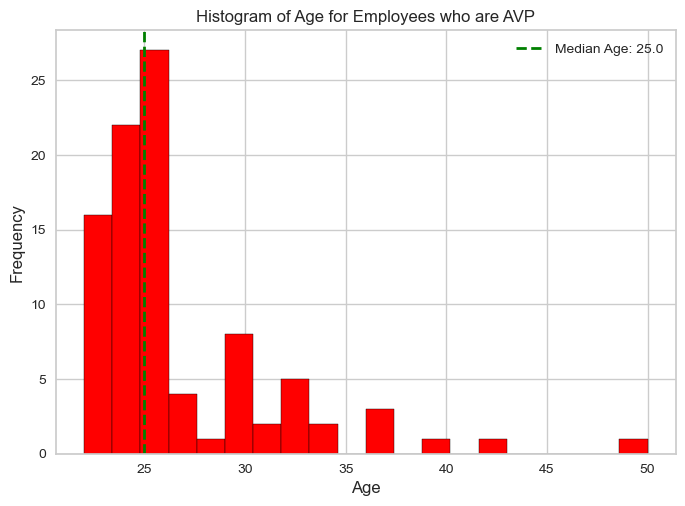

In [52]:
# Filtering the DataFrame for employees with 'AVP' equal to 1 
higher_apprentices_df = df[df['AVP'] == 1]

# Plot a histogram for the 'age' column in the filtered DataFrame
plt.hist(higher_apprentices_df['age'], bins=20, color='red', edgecolor='black')

# Calculating the median age
median_age = higher_apprentices_df['age'].median()

# Adding a vertical line at the median age
plt.axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median Age: {median_age}')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age for Employees who are AVP')
plt.legend()

plt.show()

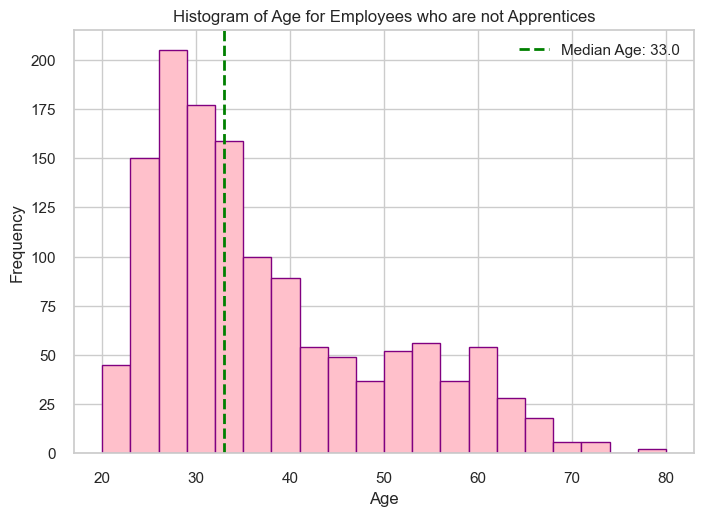

In [80]:
# Filtering the DataFrame for 'NO APPRENTICESHIP' only
no_apprentices_df = df[df['APPRENTICESHIP_TYPE'] == 'NO APPRENTICESHIP']

# Plotting a histogram for the 'age' column in the filtered DataFrame
plt.hist(no_apprentices_df['age'], bins=20, color='pink', edgecolor='Purple')

# Calculating the median age
median_age = no_apprentices_df['age'].median()

# Adding a vertical line at the median age
plt.axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median Age: {median_age}')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age for Employees who are not Apprentices')
plt.legend()

plt.show()

#As seen in this data exploration the average age for employees who are not apprentices is higher than those who are apprentices

# Feature Engineering

In [41]:
# Selecting features and target variable
features = ['AGE_GROUP', 'APPRENTICESHIP_TYPE']
# Displaying the features
for feature in features:
    print(f'Unique values in {feature}: {data[feature].unique()}')

Unique values in AGE_GROUP: ['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-55' '55-59' '60-65'
 '66-70' '70+']
Unique values in APPRENTICESHIP_TYPE: ['Foundation Apprentice' 'other types or not specified'
 'Higher Apprentice' 'NO APPRENTICESHIP']


# Data Prepocessing

In [42]:
#Now that I have identified the features (AGE_GROUP and APPRENTICESHIP_TYPE) and the target variable (AVP), I  proceed to preprocess the data and split it into training and testing sets.
#Since the data is categorical it needs to be encoded


# Encoding categorical features
label_encoder = LabelEncoder()
data_encoded = data.copy()
for feature in features:
    data_encoded[feature] = label_encoder.fit_transform(df[feature])
# Splitting the data into training and testing sets
X = data_encoded[features]
y = data_encoded['AVP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Displaying the shape of training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2196, 2), (550, 2), (2196,), (550,))

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.00784313725490196, 0.4470588235294118, 0.6352941176470588, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


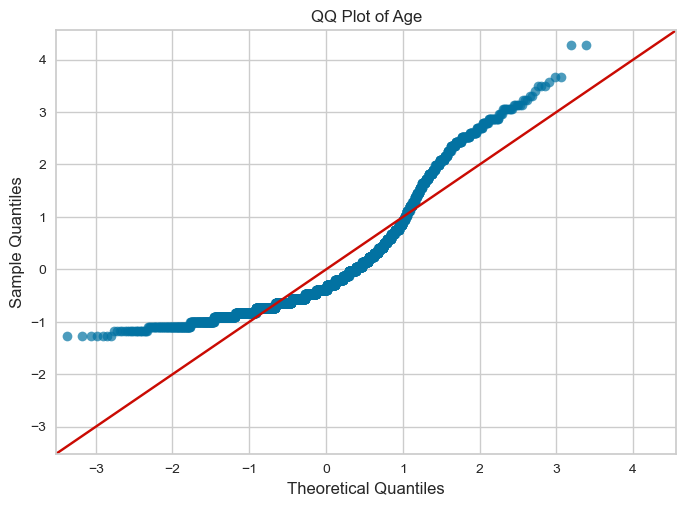

In [68]:
# Create a QQ plot for the 'age' column
sm.qqplot(df['age'], line='45', fit=True, marker='o', color='blue', alpha=0.7)

plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot of Age')

plt.show()

#The QQ plot shows that age is NOT normally distributed in the dataset

In [69]:
# D'Agostino's K^2 Test (for LARGE samples > 50)

stat, p = normaltest(df['age'])
print(p)

#The results suggest confirm the age column is NOT normally distributed. I will take this into account when building & interpreting the model

3.1000738544873394e-136


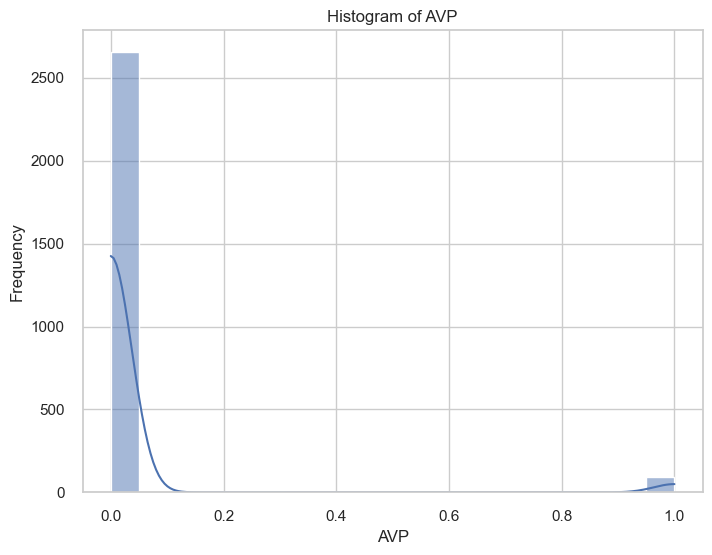

In [107]:
# Create a histogram for the target variable 'AVP'
plt.figure(figsize=(8, 6))
sns.histplot(data['AVP'], bins=20, kde=True)
plt.title('Histogram of AVP')
plt.xlabel('AVP')
plt.ylabel('Frequency')
plt.show()

In [108]:
# Conduct normality tests

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(data['AVP'])
# D'Agostino and Pearson's Test
dagostino_stat, dagostino_p = normaltest(data['AVP'])
# Skewness
data_skew = skew(data['AVP'])
shapiro_stat, shapiro_p, dagostino_stat, dagostino_p, data_skew


(0.17281830310821533, 0.0, 2733.816864096355, 0.0, 5.153827352127498)

### Normality tests

Shapiro Statistic (shapiro_stat): Approximately 0.173
Shapiro p-value (shapiro_p): Approximately 0.000 (rounded)
The Shapiro-Wilk test p-value is very close to zero (0.000), indicating that the 'AVP' variable significantly deviates from a normal distribution. In other words, the data is not normally distributed.

D'Agostino and Pearson's Test:

D'Agostino-Pearson Statistic (dagostino_stat): Approximately 2733.817
D'Agostino-Pearson p-value (dagostino_p): Approximately 0.000 (rounded)
Similar to the Shapiro-Wilk test, the D'Agostino and Pearson's test p-value is very close to zero (0.000), indicating that the 'AVP' variable significantly deviates from a normal distribution.

Skewness:

Data Skew (data_skew): Approximately 5.154
The skewness value of approximately 5.154 indicates that the 'AVP' variable is highly positively skewed. This means that the distribution has a long tail to the right, and most of the data points are concentrated on the left side of the distribution.

In summary, both normality tests suggest that the 'AVP' variable does not follow a normal distribution, and the skewness value confirms that it is highly positively skewed. Therefore, the 'AVP' variable is not normally distributed, and this should be taken into consideration when performing statistical analyses or modeling.

In [77]:
data.head(100)

,AGE_GROUP,AVP,BA4,BRID,CORPORATE_GRADE,APPRENTICESHIP_TYPE,age
0,18-24,0,0,G01111049,BA2,Foundation Apprentice,17
1,18-24,0,0,G01111050,BA2,Foundation Apprentice,17
2,18-24,0,0,G01111051,BA2,other types or not specified,17
3,18-24,0,0,G01111052,BA2,Foundation Apprentice,17
4,18-24,0,0,G01111053,BA2,Higher Apprentice,17
...,...,...,...,...,...,...,...
95,18-24,0,0,G01111144,BA2,Higher Apprentice,19
96,18-24,0,0,G01111145,BA2,Foundation Apprentice,19
97,18-24,0,0,G01111146,BA2,Foundation Apprentice,19
98,18-24,0,0,G01111147,BA2,Foundation Apprentice,19


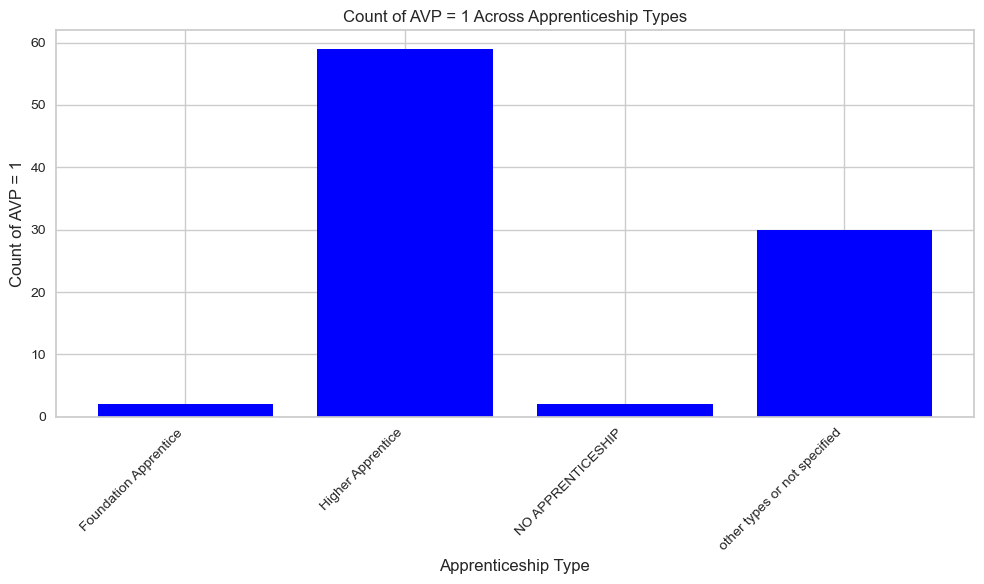

In [100]:
# Filter the DataFrame for rows where 'AVP' is equal to 1
avp_1_counts = df[df['AVP'] == 1].groupby('APPRENTICESHIP_TYPE').size().reset_index(name='AVP_1_Count')

plt.figure(figsize=(10, 6))
plt.bar(avp_1_counts['APPRENTICESHIP_TYPE'], avp_1_counts['AVP_1_Count'], color='blue')
plt.xlabel('Apprenticeship Type')
plt.ylabel('Count of AVP = 1')
plt.title('Count of AVP = 1 Across Apprenticeship Types')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [101]:
# Create a contingency table
contingency_table = pd.crosstab(df['APPRENTICESHIP_TYPE'], df['AVP'])

# Perform a chi-squared test
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Print the results
print("Chi-Squared Test Results:")
print(f"Chi-Squared Value: {chi2}")
print(f"P-value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: There is a significant association between AVP and Apprenticeship Type.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between AVP and Apprenticeship Type.")

Chi-Squared Test Results:
Chi-Squared Value: 146.87140632671674
P-value: 1.246279287504872e-31
Reject the null hypothesis: There is a significant association between AVP and Apprenticeship Type.


In [103]:
# Create a contingency table
contingency_table = pd.crosstab(df['AGE_GROUP'], df['AVP'])

# Perform a chi-squared test
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Print the results
print("Chi-Squared Test Results:")
print(f"Chi-Squared Value: {chi2}")
print(f"P-value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: There is a significant association between AVP and Age Group.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between AVP and Age Group.")

Chi-Squared Test Results:
Chi-Squared Value: 28.80192777403307
P-value: 0.0013414201832421698
Reject the null hypothesis: There is a significant association between AVP and Age Group.


In [22]:
# Assuming you have a DataFrame called 'df'
contingency_table = pd.crosstab(df['BA4'], df['APPRENTICESHIP_TYPE'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Print the results
print("Chi-Squared Test Results:")
print(f"Chi-Squared Value: {chi2}")
print(f"P-value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: There is a significant association between BA4 status and Apprenticeship Type.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between BA4 status and Apprenticeship Type.")


Chi-Squared Test Results:
Chi-Squared Value: 288.71000891587255
P-value: 2.7611222167218607e-62
Reject the null hypothesis: There is a significant association between BA4 status and Apprenticeship Type.


# Creating the logistic regression model 

In [105]:
# Initialize the logistic regression model
log_reg = LogisticRegression(random_state=42)
# Train the model
log_reg.fit(X_train, y_train)
# Make predictions on the test set
y_pred = log_reg.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9727272727272728

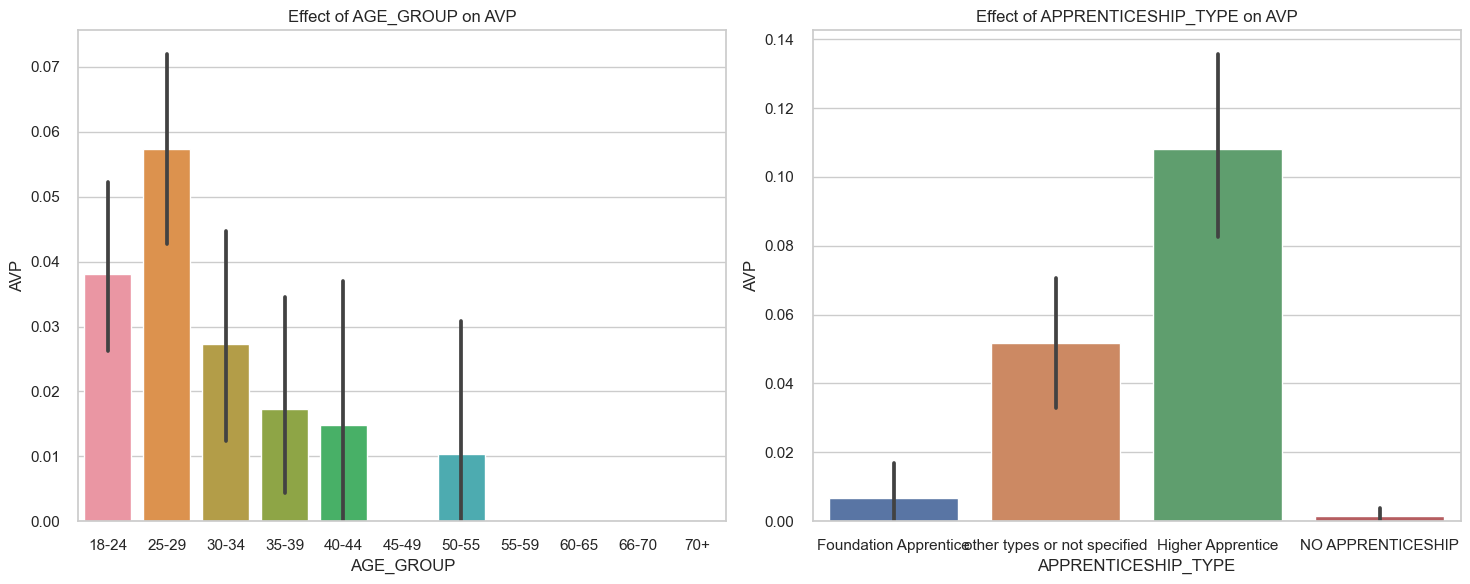

In [106]:
# Set the style for the plot
sns.set(style='whitegrid')
# Create a figure and axis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot the effect of AGE_GROUP on AVP
sns.barplot(x='AGE_GROUP', y='AVP', data=data, ax=axes[0])
axes[0].set_title('Effect of AGE_GROUP on AVP')
# Plot the effect of APPRENTICESHIP_TYPE on AVP
sns.barplot(x='APPRENTICESHIP_TYPE', y='AVP', data=data, ax=axes[1])
axes[1].set_title('Effect of APPRENTICESHIP_TYPE on AVP')
# Show the plot
plt.tight_layout()
plt.show()

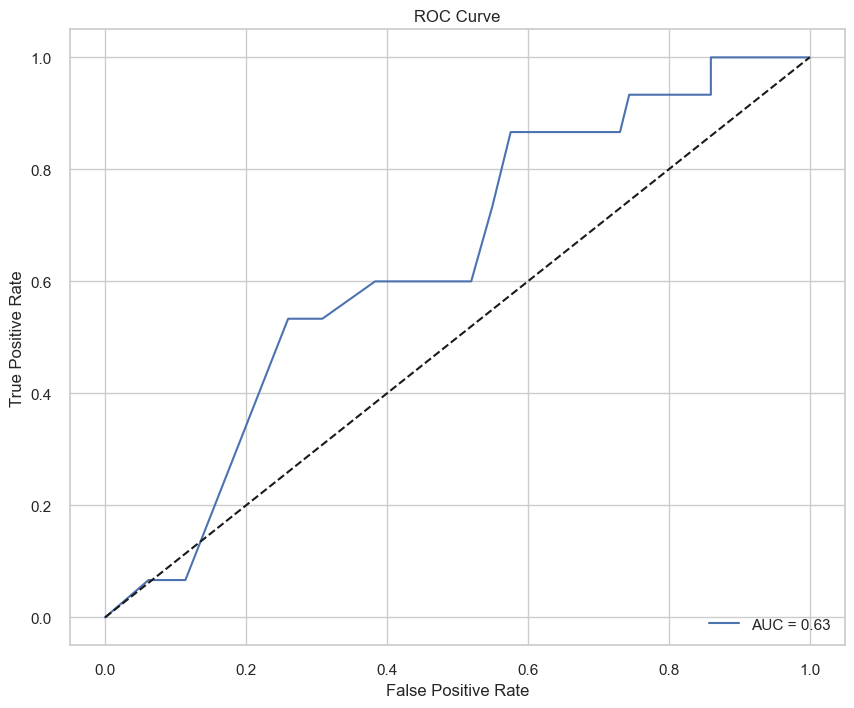

0.6348909657320873

In [109]:
# Calculate the predicted probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
auc

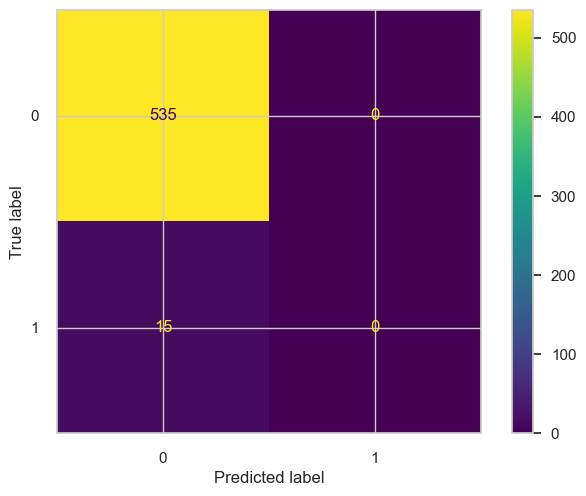

In [111]:
# Generate predictions using log_reg (not logreg)
y_pred = log_reg.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_).plot()


In [ ]:
#Type II Error (False Negative): This occurs when the model incorrectly predicts a negative outcome when the true outcome is positive. It means that the model fails to detect a positive event that did occur.

#In your case, having 15 False Negatives out of a total of 15 positive cases is an example of a Type II error. It's important to consider the implications of Type II errors in your specific application, as they represent instances where your model failed to identify positive cases.

# Creating a New Logistic Regression Model
In this new model, we will use BA4 as the dependent variable while keeping the features (AGE_GROUP and APPRENTICESHIP_TYPE) the same.

In [49]:
# Perform one-hot encoding on the 'AGE_GROUP' and 'APPRENTICESHIP_TYPE' columns
X_new_encoded = pd.get_dummies(X_new, columns=['AGE_GROUP', 'APPRENTICESHIP_TYPE'], drop_first=True)

# Features and new target variable
y_new = df['BA4']
# Splitting the data into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new_encoded, y_new, test_size=0.2, random_state=42)

# Initialize the new Logistic Regression model
logreg_new = LogisticRegression()
# Fit the new model
logreg_new.fit(X_train_new, y_train_new)

LogisticRegression()

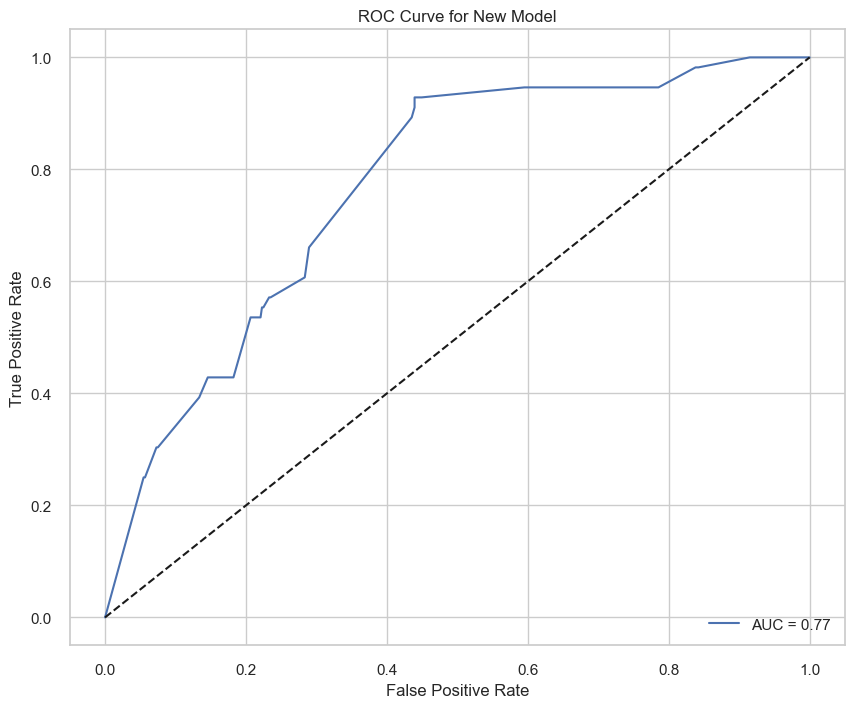

0.7681644013880855

In [50]:
# Calculate the predicted probabilities for the new model
y_pred_prob_new = logreg_new.predict_proba(X_test_new)[:, 1]
# Compute ROC curve and AUC for the new model
fpr_new, tpr_new, thresholds_new = roc_curve(y_test_new, y_pred_prob_new)
auc_new = roc_auc_score(y_test_new, y_pred_prob_new)
# Plot the ROC curve for the new model
plt.figure(figsize=(10, 8))
plt.plot(fpr_new, tpr_new, label=f'AUC = {auc_new:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for New Model')
plt.legend(loc='lower right')
plt.show()
auc_new

In [51]:
# Check the shape of X_new
print("Shape of X_new:", X_new.shape)

# Check the shape of the coefficients array
print("Shape of coefficients:", logreg_new.coef_.shape)


Shape of X_new: (2746, 2)
Shape of coefficients: (1, 13)


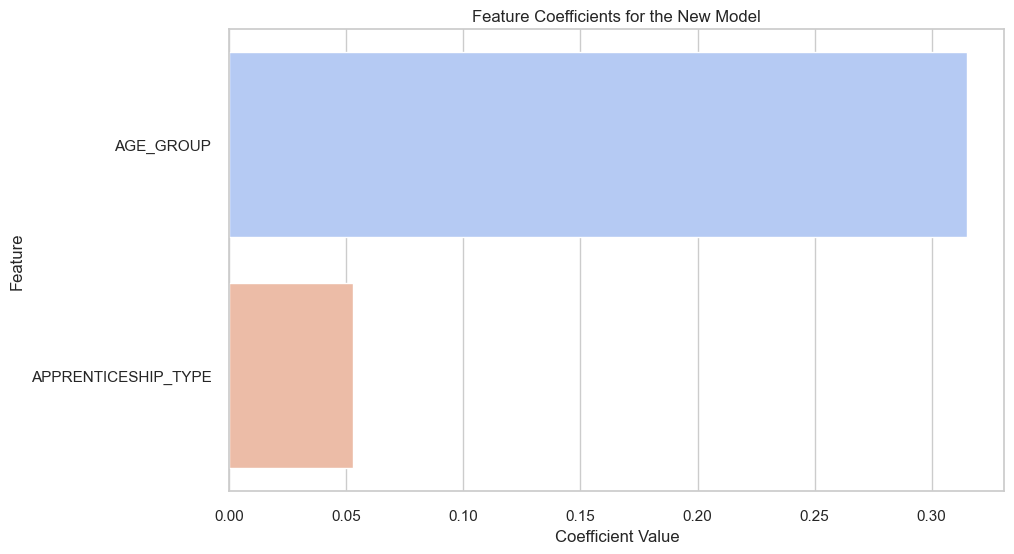

In [52]:
# Get the coefficients from the new logistic regression model
coefficients_new = pd.DataFrame({'Feature': X_new.columns, 'Coefficient': logreg_new.coef_[0][:X_new.shape[1]]})
# Sort the coefficients by their absolute values
coefficients_new['abs_coef'] = coefficients_new['Coefficient'].abs()
coefficients_new = coefficients_new.sort_values(by='abs_coef', ascending=False)
# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_new, palette='coolwarm')
plt.title('Feature Coefficients for the New Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


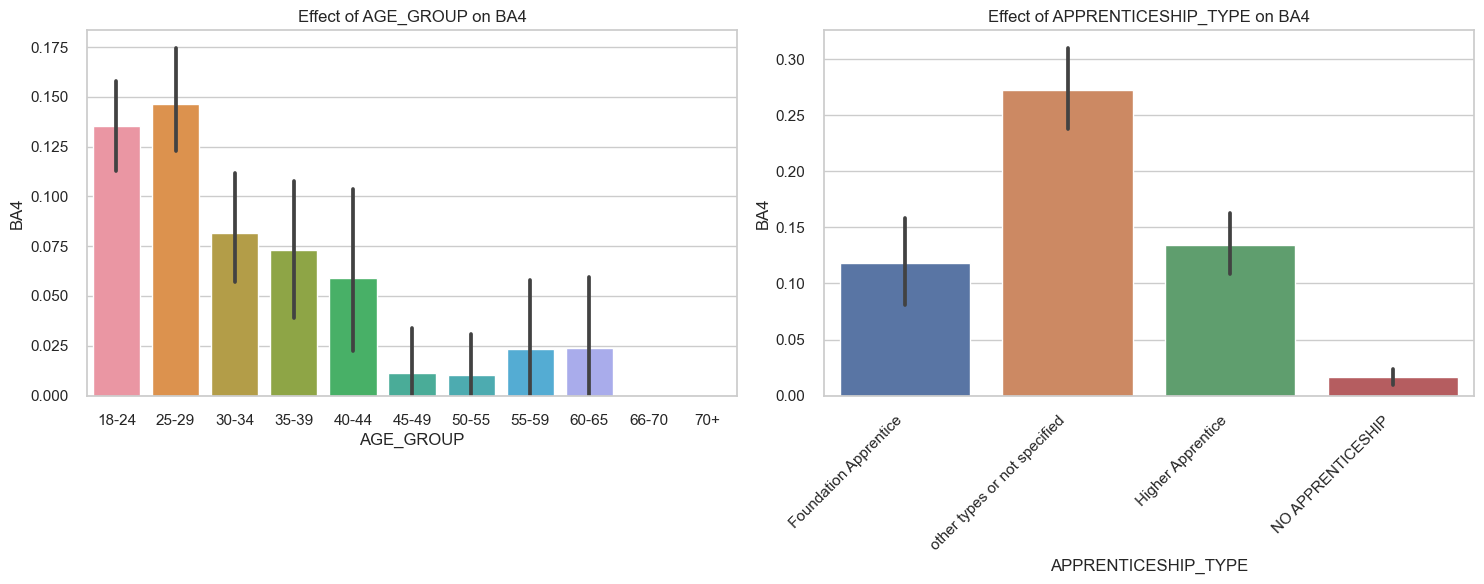

In [60]:
# Set the style for the plot
sns.set(style='whitegrid')

# Create a figure and axis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the effect of AGE_GROUP on BA4
sns.barplot(x='AGE_GROUP', y='BA4', data=df, ax=axes[0])
axes[0].set_title('Effect of AGE_GROUP on BA4')

# Plot the effect of APPRENTICESHIP_TYPE on BA4
sns.barplot(x='APPRENTICESHIP_TYPE', y='BA4', data=df, ax=axes[1])
axes[1].set_title('Effect of APPRENTICESHIP_TYPE on BA4')

# set the text
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')

# Show the plot
plt.tight_layout()
plt.show()


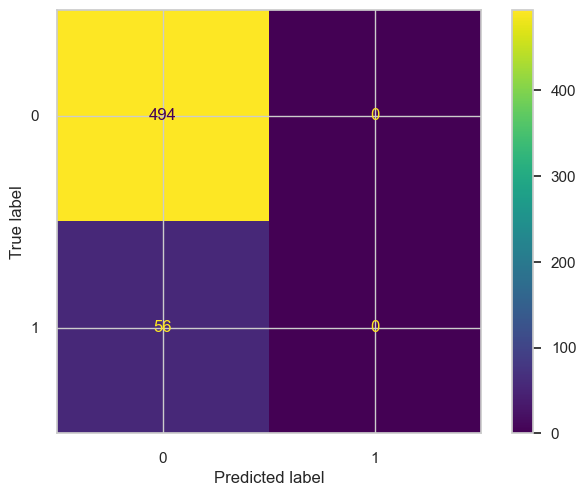

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions using log_reg
y_pred = logreg_new.predict(X_test_new)

# Create the confusion matrix
cm = confusion_matrix(y_test_new, y_pred)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_new.classes_).plot()


# Key Findings
In the analysis of these two models, several discoveries have come to light:

**Apprenticeships Enhance Promotion Opportunities:** Undertaking an apprenticeship significantly increases an employee's chances of promotion. Both Higher Apprenticeships and other types of apprenticeships are associated with higher rates of achieving AVP corporate grade status compared to non-apprentices.

**Apprenticeship Types Matter:** Different apprenticeship types yield varying rates of AVP status attainment. Regardless of the specific type, all apprenticeships outperform non-apprentices in terms of AVP status achievement. Foundation apprenticeships increase the likelihood of reaching BA4 grade, while degree-level apprenticeships significantly elevate the chances of attaining Assistant Vice President (AVP) grade.

**Success of Destination Technology Apprenticeships:** Destination Technology apprenticeships stand out as particularly successful, leading to a significant number of promotions to both BA4 and AVP levels. This indicates the effectiveness of this specific apprenticeship program in fostering career growth.

**Age Range Influence:** The analysis suggests that age range plays a role in corporate grade attainment. Employees in the age range of 25-29 have a higher chance of reaching AVP level as well as BA4 Level. This may be attributed to the age at which many people complete their apprenticeships, providing them with a few more years of experience before reaching this age bracket. However, there appears to be under-representation of older age groups in higher grades, which could indicate potential opportunities for addressing this gap.

